# Automatic tagging 

- Applying deep learning concepts

# 1)- Importing key modules

In [0]:
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [0]:
import os
import pickle as pkl
import re
import string

In [0]:
# for data processing

import numpy as np
import itertools
import pandas as pd 
from sklearn.model_selection import train_test_split
import tqdm

In [87]:
# for text 

import nltk
import re 
from nltk import tokenize
import nltk
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
lemm = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
# for deep learning

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Input
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model

from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

from keras.utils import to_categorical

# For evaluation

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [0]:
# For visuals

import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
% matplotlib inline 
pd.set_option('display.max_colwidth', 200)

In [90]:
! pip install version_information

In [91]:
# first install: pip install version_information
%reload_ext version_information
%version_information pandas,numpy,keras, sklearn,nltk, seaborn, matplotlib

Software,Version
Python,3.6.9 64bit [GCC 8.3.0]
IPython,5.5.0
OS,Linux 4.19.80+ x86_64 with Ubuntu 18.04 bionic
pandas,0.25.3
numpy,1.17.5
keras,2.2.5
sklearn,0.22.1
nltk,3.2.5
seaborn,0.9.0
matplotlib,3.1.2


# 2)- Reading Dataset

Thanks to PyData 2018: Gilbert Francois Talk

In [92]:
data=pd.read_pickle('sentiment_self_drive.pkl')
data.shape

(6943, 2)

In [93]:
data.head()

,text,sent_numeric
0,Two places I'd invest all my money if I could: 3D printing and Self-driving cars!!!,Beneficial
1,Awesome! Google driverless cars will help the blind travel more often; https://t.co/QWuXR0FrBpv,Beneficial
2,"If Google maps can't keep up with road construction, how am I supposed to trust a driverless car to get around here?",Risky
3,Autonomous cars seem way overhyped given the technology challenges; pilotless planes seem much more doable and needed.,Risky
4,Just saw Google self-driving car on I-34. It was painted green and blue.,Neutral


In [94]:
data.tail()

,text,sent_numeric
7141,Florida is one of a few states that allows testing of autonomous vehicles #sayfie,Neutral
7142,Many states still considering allowing self-driving car testing,Neutral
7143,Heading to a tech conference which will focus on transportation and driverless cars #AV #Innovation,Neutral
7144,Fully autonomous vehicles are one of many automation technologies,Neutral
7145,A new study just commissioned to study the costs of self-driving cars,Neutral


In [95]:
data['sent_numeric'].unique()

array(['Beneficial', 'Risky', 'Neutral'], dtype=object)

# Class	Description
- 1	Too late, away during office hours or early leave
- 2	Holidays or scheduled free days
- 3	Home Office
 -4	Medical appointment
- 5	Ill, without consulting a medical
- 6	Work related absence (at client, conference)
- 7	In office announcement
- 8	Miscellanious

In [0]:
dict_classes = {
    1: 'Benefit',
    2: 'Risky',
    3: 'miscellanious'
}

In [97]:
data['sent_numeric'].value_counts()

Neutral       4245
Beneficial    1903
Risky          795
Name: sent_numeric, dtype: int64

In [0]:
df=data[['text','sent_numeric']]

In [99]:
type(df)

pandas.core.frame.DataFrame

In [100]:
df.head()

,text,sent_numeric
0,Two places I'd invest all my money if I could: 3D printing and Self-driving cars!!!,Beneficial
1,Awesome! Google driverless cars will help the blind travel more often; https://t.co/QWuXR0FrBpv,Beneficial
2,"If Google maps can't keep up with road construction, how am I supposed to trust a driverless car to get around here?",Risky
3,Autonomous cars seem way overhyped given the technology challenges; pilotless planes seem much more doable and needed.,Risky
4,Just saw Google self-driving car on I-34. It was painted green and blue.,Neutral


### checking missing value if any

In [101]:
df.isnull().sum()

text            0
sent_numeric    0
dtype: int64

## Label categorical values

In [0]:
# further check
df['labels'] = df.sent_numeric.map({'Risky':0, 'Beneficial':1, 'Neutral':2})

### Separating X and y

In [0]:
X = df['text']
y = df['labels']

In [104]:
X[:5]

0                                       Two places I'd invest all my money if I could: 3D printing and Self-driving cars!!!
1                           Awesome! Google driverless cars will help the blind travel more often; https://t.co/QWuXR0FrBpv
2      If Google maps can't keep up with road construction, how am I supposed to trust a driverless car to get around here?
3    Autonomous cars seem way overhyped given the technology challenges; pilotless planes seem much more doable and needed.
4                                                  Just saw Google self-driving car on I-34. It was painted green and blue.
Name: text, dtype: object

In [105]:
y[:5]

0    1
1    1
2    0
3    0
4    2
Name: labels, dtype: int64

# 3)- Pre-model process

In [0]:
# Embedding
max_features = 3000
maxlen = 50
embedding_size = 100

# Convolution
kernel_size = 5
filters = 64
pool_size = 4

# LSTM
lstm_output_size = 70

# Training
batch_size = 20
epochs = 12

### 3a)-Tokenizing

In [0]:

tokenizer = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True, split=' ', char_level=False)
tokenizer.fit_on_texts(X)
Xt = tokenizer.texts_to_sequences(X)

In [108]:
print(X.iloc[2])

If Google maps can't keep up with road construction, how am I supposed to trust a driverless car to get around here?


In [109]:
print(Xt[2])

[42, 9, 242, 93, 446, 76, 27, 84, 1211, 41, 200, 15, 1212, 11, 291, 10, 12, 5, 11, 59, 132, 113]


In [110]:
# word to index
word_index = tokenizer.word_index
num_words = len(word_index)
print('Number of words in the corpus: {}'.format(num_words))

Number of words in the corpus: 15670


In [111]:
len_list = np.array([len(x) for x in Xt])
mean_len = np.mean(len_list)
std_len = np.std(len_list)
print(mean_len, std_len)

17.529742186374765 5.54335053584562


### 3b)-Multi Label Binarizer

In [0]:
# keras needs inputs to be vectors , so one hot encoding values
from keras.utils import np_utils
def one_hot_encode_object_array(arr):
    '''One hot encode a numpy array of objects (e.g. strings)'''
    uniques, ids = np.unique(arr, return_inverse=True)
    return np_utils.to_categorical(ids, len(uniques))

yc=one_hot_encode_object_array(y)

In [113]:
#yc = to_categorical(y-1)
yc[:10]

array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

### 3c)-Sequence padding
Make all input vectors the same size by truncating or adding zeros.

In [0]:
Xts = sequence.pad_sequences(Xt, maxlen=maxlen, padding='post')

In [115]:
print(X[1])

Awesome! Google driverless cars will help the blind travel more often; https://t.co/QWuXR0FrBpv


In [116]:
print(Xt[1])

[180, 9, 12, 8, 20, 304, 7, 570, 713, 79, 2483, 139, 3, 4, 4758]


In [117]:
print(Xts[1])

[ 180    9   12    8   20  304    7  570  713   79 2483  139    3    4
 4758    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


### 3d)- Split dataset

In [0]:
X_train, X_test, y_train, y_test = train_test_split(Xts, yc, test_size=0.10, random_state=1)

In [119]:

print('X_train shape: {}'.format(X_train.shape))
print('X_test shape : {}'.format(X_test.shape))

print('y_train shape: {}'.format(y_train.shape))
print('y_test shape : {}'.format(y_test.shape))

X_train shape: (6248, 50)
X_test shape : (695, 50)
y_train shape: (6248, 3)
y_test shape : (695, 3)


# 4)- Model Building

In [0]:
def build_and_train_model(X_train, X_test, y_train, y_test, verbose=1):
    print('Build model...')
    model = Sequential()
    model.add(Embedding(max_features, embedding_size, input_length=maxlen))
    model.add(Dropout(0.25))
    model.add(Conv1D(filters,
                     kernel_size,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(LSTM(lstm_output_size))
    model.add(Dense(3))
    model.add(Activation('softmax'))

    callback = EarlyStopping(monitor='val_acc', patience=2) # avoid over-fitting

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    print('Training the model...')
    H = model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_test, y_test), callbacks=[callback], verbose=verbose)
  
    score, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
    print('Test accuracy:', acc)
    return model, H, acc

### training the model

In [121]:
model, H, acc = build_and_train_model(X_train, X_test, y_train, y_test)

Build model...
Training the model...
Train on 6248 samples, validate on 695 samples
Epoch 1/12
6248/6248 [==============================] - 10s 2ms/step - loss: 0.8537 - acc: 0.6316 - val_loss: 0.8043 - val_acc: 0.6849
Epoch 2/12
6248/6248 [==============================] - 7s 1ms/step - loss: 0.6949 - acc: 0.7214 - val_loss: 0.8203 - val_acc: 0.6935
Epoch 3/12
6248/6248 [==============================] - 7s 1ms/step - loss: 0.5696 - acc: 0.7737 - val_loss: 0.7874 - val_acc: 0.7209
Epoch 4/12
6248/6248 [==============================] - 7s 1ms/step - loss: 0.4101 - acc: 0.8449 - val_loss: 0.9081 - val_acc: 0.6230
Epoch 5/12
695/695 [==============================] - 0s 389us/step
Test accuracy: 0.6805755431703526


### Visualization

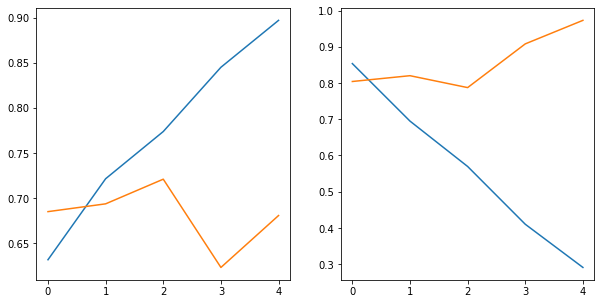

In [122]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(H.history['acc'], label='acc')
axs[0].plot(H.history['val_acc'], label='val_acc')
axs[1].plot(H.history['loss'], label='loss')
axs[1].plot(H.history['val_loss'], label='val_loss')

### Prediction

In [0]:
y_pred = model.predict(X_test)

In [124]:
y_pred[:5]

array([[2.3988366e-02, 1.8139932e-02, 9.5787168e-01],
       [8.0569589e-04, 3.9950106e-03, 9.9519926e-01],
       [7.6213598e-01, 1.1701136e-01, 1.2085271e-01],
       [1.1067881e-03, 2.9516413e-03, 9.9594158e-01],
       [1.6259765e-02, 1.3190781e-01, 8.5183239e-01]], dtype=float32)

In [0]:
y_pred_class=np.argmax(y_pred, axis=1)

In [126]:
y_pred_class[:5]

array([2, 2, 0, 2, 2])

In [127]:
# true values
y_test[:5]

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [0]:
y_test_class=np.argmax(y_test, axis=1)

In [129]:
print(classification_report(y_pred=y_pred_class, y_true=y_test_class))

              precision    recall  f1-score   support

           0       0.35      0.20      0.25        80
           1       0.58      0.55      0.56       191
           2       0.75      0.83      0.79       424

    accuracy                           0.68       695
   macro avg       0.56      0.53      0.54       695
weighted avg       0.66      0.68      0.67       695



- 0 is Beneficial
- 1 is Neutral 
- 2 is Risky

### confusion matrix

In [130]:
! pip install scikit-plot

In [131]:
cm = confusion_matrix(y_pred_class, y_test_class)
cm

array([[ 16,  10,  20],
       [ 24, 105,  52],
       [ 40,  76, 352]])

<Figure size 432x288 with 0 Axes>

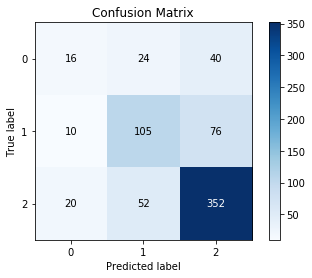

In [132]:
import scikitplot as skplt
plt.figure()
skplt.metrics.plot_confusion_matrix(y_pred=y_pred_class, y_true=y_test_class)
plt.show()

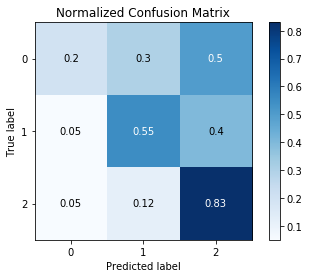

In [133]:
skplt.metrics.plot_confusion_matrix(y_pred=y_pred_class, y_true=y_test_class, normalize=True)

# 5)- Training an ensemble model

Since we do early stopping, to minimise overfitting, the model is not fully trained yet. The effect of random initialisation is noticable. Hence, when training e.g. 10 times from scratch, you end up with 10 models with different performance. An idea to smooth this effect is to train multiple times and use all models for the prediction. Add all resulting output vectors and take the $argmax$. This will be your final prediction.

In [134]:
n_models = 10

model_list = []
H_list = []
acc_list = []
for i in range(n_models):
    print('Training model {}'.format(i+1))
    _model, _H, _acc = build_and_train_model(X_train, X_test, y_train, y_test, verbose=0)
    model_list.append(_model)
    H_list.append(_H)
    acc_list.append(_acc)

Training model 1
Build model...
Training the model...
695/695 [==============================] - 0s 397us/step
Test accuracy: 0.656115105683855
Training model 2
Build model...
Training the model...
695/695 [==============================] - 0s 401us/step
Test accuracy: 0.6460431616940945
Training model 3
Build model...
Training the model...
695/695 [==============================] - 0s 381us/step
Test accuracy: 0.6647481999808936
Training model 4
Build model...
Training the model...
695/695 [==============================] - 0s 386us/step
Test accuracy: 0.6791366870454747
Training model 5
Build model...
Training the model...
695/695 [==============================] - 0s 397us/step
Test accuracy: 0.6949640328077962
Training model 6
Build model...
Training the model...
695/695 [==============================] - 0s 383us/step
Test accuracy: 0.6719424424411582
Training model 7
Build model...
Training the model...
695/695 [==============================] - 0s 387us/step
Test accuracy: 0.674

In [135]:
print('Mean test accuracy: {:.3f}'.format(np.mean(np.array(acc_list))))

Mean test accuracy: 0.669


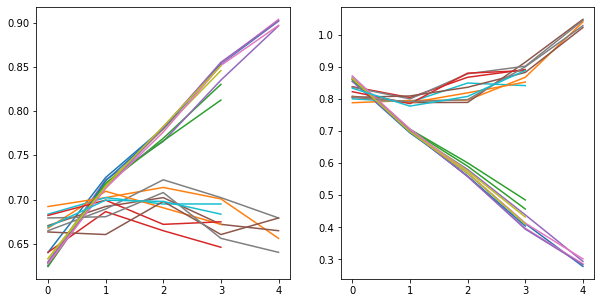

In [136]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for H in H_list:
    axs[0].plot(H.history['acc'], label='acc')
    axs[0].plot(H.history['val_acc'], label='val_acc')
    axs[1].plot(H.history['loss'], label='loss')
    axs[1].plot(H.history['val_loss'], label='val_loss')

In [0]:
y_pred_list = []
for index in range(len(X_test)):
    y_pred = np.zeros(3)
    for model in model_list:
        y_pred += model.predict(X_test[index][np.newaxis])[0]
    y_pred_list.append(y_pred)
    
y_pred = np.array(y_pred_list)

In [138]:
y_pred[:5]

array([[0.45943071, 0.37436493, 9.16620445],
       [0.01756018, 0.06378194, 9.91865778],
       [5.85241933, 1.38007518, 2.76750538],
       [0.03771679, 0.07314094, 9.88914233],
       [0.72820715, 5.52399271, 3.74780009]])

In [0]:
y_pred_class=np.argmax(y_pred, axis=1)

In [140]:
y_pred_class[:5]

array([2, 2, 0, 2, 1])

In [141]:
# true values
y_test[:5]

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [0]:
y_test_class=np.argmax(y_test, axis=1)

In [143]:
y_test_class[:5]

array([2, 2, 1, 2, 2])

In [144]:
accuracy_score(y_pred_class, y_test_class)

0.697841726618705

In [145]:
print(classification_report(y_pred_class, y_test_class))

              precision    recall  f1-score   support

           0       0.26      0.44      0.33        48
           1       0.60      0.60      0.60       190
           2       0.83      0.77      0.79       457

    accuracy                           0.70       695
   macro avg       0.56      0.60      0.57       695
weighted avg       0.72      0.70      0.71       695



<Figure size 432x288 with 0 Axes>

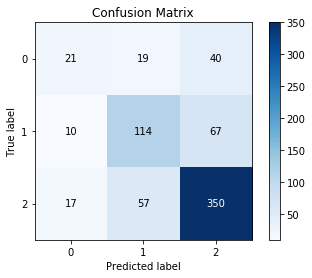

In [146]:
import scikitplot as skplt
plt.figure()
skplt.metrics.plot_confusion_matrix(y_pred=y_pred_class, y_true=y_test_class)
plt.show()

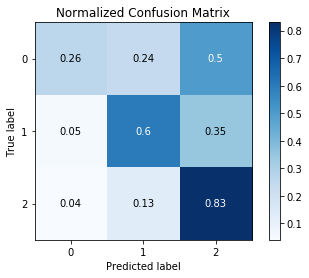

In [147]:
skplt.metrics.plot_confusion_matrix(y_pred=y_pred_class, y_true=y_test_class, normalize=True)

# 6)- Checking out of sample data

In [0]:
def tag_message(message):
    X_new = tokenizer.texts_to_sequences([message])
    x1_new = sequence.pad_sequences(X_new, maxlen=maxlen, padding='post')
    y_pred_list = []
    for model in model_list:
        y_pred_list.append(model.predict(x1_new))
    y_pred = np.argmax(np.sum(np.array(y_pred_list), axis=0) / 10.0)
    print('{:>20} | {}'.format(dict_classes[y_pred], message))

In [149]:
tag_message('My alarm clock was not set properly. I come to the office asap.')
tag_message('It is my scheduled day off.')
tag_message('See you on Wednesday.')
tag_message('Not feeling well today, I had to vomit.')
tag_message('I work at home on Tuesday.')
tag_message('This morning I have a meeting at ACME.')
tag_message('The roads are super slippery, will miss the daily')
tag_message('get well soon!')
tag_message('I\'m away for a long lunch between 12:00 and 15:30')
tag_message('I have an appointment at the physio.')

               Risky | My alarm clock was not set properly. I come to the office asap.
               Risky | It is my scheduled day off.
               Risky | See you on Wednesday.
               Risky | Not feeling well today, I had to vomit.
               Risky | I work at home on Tuesday.
               Risky | This morning I have a meeting at ACME.
             Benefit | The roads are super slippery, will miss the daily
               Risky | get well soon!
             Benefit | I'm away for a long lunch between 12:00 and 15:30
               Risky | I have an appointment at the physio.


# 7)-Transfer learning with pretrained embeddings

### 7.1)- USe GloVe Word - Embedding 

In [150]:
# download the file
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-01-17 15:09:52--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-01-17 15:09:52--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-01-17 15:09:52--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

In [151]:
# unzip it

!unzip glove*.zip

Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [152]:
# Get the exact path of where the embedding vectors are extracted using
!ls
!pwd

glove.6B.100d.txt  glove.6B.50d.txt  Out_of_sample.pkl
glove.6B.200d.txt  glove.6B.zip      sample_data
glove.6B.300d.txt  glove.6B.zip.1    sentiment_self_drive.pkl
/content


In [153]:
# Index the vectors

print('Indexing word vectors.')

embeddings_index = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


### 7.2)- loading file for pretrained embeddings

In [154]:
embeddings_index = {}
with open('glove.6B.100d.txt', 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [155]:
embeddings_index['home'].shape

(100,)

In [156]:
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
print(embedding_matrix.shape)

(15671, 100)


### 7.3)-Model Building

In [158]:
print('Build model...')

model = Sequential()
# model.add(Input(shape=(maxlen,), dtype='int32'))
model.add(Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add(Dropout(0.25))
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(LSTM(lstm_output_size))
model.add(Dense(3))
model.add(Activation('softmax'))

callback = EarlyStopping(monitor='val_acc', patience=1)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
H = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, y_test), callbacks=[callback])
score, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Build model...
Train...
Train on 6248 samples, validate on 695 samples
Epoch 1/12
6248/6248 [==============================] - 13s 2ms/step - loss: 0.8717 - acc: 0.6136 - val_loss: 0.8576 - val_acc: 0.5971
Epoch 2/12
6248/6248 [==============================] - 7s 1ms/step - loss: 0.8215 - acc: 0.6288 - val_loss: 0.8095 - val_acc: 0.6302
Epoch 3/12
6248/6248 [==============================] - 7s 1ms/step - loss: 0.7851 - acc: 0.6570 - val_loss: 0.7920 - val_acc: 0.6705
Epoch 4/12
6248/6248 [==============================] - 7s 1ms/step - loss: 0.7278 - acc: 0.6817 - val_loss: 0.7666 - val_acc: 0.6748
Epoch 5/12
6248/6248 [==============================] - 7s 1ms/step - loss: 0.6929 - acc: 0.7093 - val_loss: 0.7785 - val_acc: 0.6777
Epoch 6/12
695/695 [==============================] - 0s 418us/step
Test score: 0.8139248807653249
Test accuracy: 0.6618705048835535


In [0]:
y_pred = model.predict(X_test)

### 7.4)- Results

In [160]:
accuracy_score(y_pred=np.argmax(y_pred, axis=1), y_true=np.argmax(y_test, axis=1))

0.6618705035971223

In [161]:
print(classification_report(y_pred=np.argmax(y_pred, axis=1), y_true=np.argmax(y_test, axis=1)))

              precision    recall  f1-score   support

           0       0.44      0.09      0.15        80
           1       0.52      0.48      0.50       191
           2       0.72      0.85      0.78       424

    accuracy                           0.66       695
   macro avg       0.56      0.47      0.48       695
weighted avg       0.63      0.66      0.63       695



In [162]:
cm = confusion_matrix(y_pred=np.argmax(y_pred, axis=1), y_true=np.argmax(y_test, axis=1))
cm

array([[  7,  27,  46],
       [  5,  92,  94],
       [  4,  59, 361]])

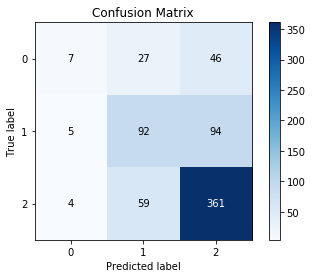

In [163]:
skplt.metrics.plot_confusion_matrix(y_pred=np.argmax(y_pred, axis=1), y_true=np.argmax(y_test, axis=1))
plt.show()

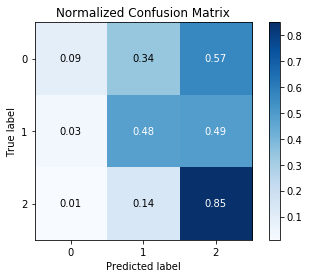

In [164]:
skplt.metrics.plot_confusion_matrix(y_pred=np.argmax(y_pred, axis=1), y_true=np.argmax(y_test, axis=1), normalize=True)
plt.show()

**END of NOTEBOOK**